In [2]:
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask

import seaborn as sns

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as imag
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as mticker
import types


import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import csv
import pandas as pd
import os

from mpl_toolkits.basemap import Basemap
bm = Basemap()

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [3]:
import types
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left")
    self.offsetText.set_position(
            (0, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72.0))


def register_bottom_offset(axis, func):
    axis._update_offset_text_position = types.MethodType(func, axis)

In [4]:
path_to_file = '/fast/gmooers/Preprocessed_Data/7_Years_Spaced/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/Jordan_Best.nc'
predict_ds = xr.open_dataset(path_to_file)

In [6]:
precip_real_ds = real_ds.targets[:, -1].values
precip_test_ds = predict_ds.Prediction[:, -1].values

heat_real_ds = real_ds.targets[:, :30].values
heat_test_ds = predict_ds.Prediction[:, :30].values

moist_real_ds = real_ds.targets[:, 30:60].values
moist_test_ds = predict_ds.Prediction[:, 30:60].values

times = real_ds.time.values

lats = np.linspace(-90.0, 90.0, 96)
lons = np.linspace(0.0, 357.5, 144)

Xvar, Yvar = np.meshgrid(lons, lats)

x = 144
y = 96
z = 30
t = int(len(precip_real_ds)/(x*y))
print(t)

3420


In [7]:
others = netCDF4.Dataset("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
lons = np.array(others.variables['lon'])
lats = np.array(others.variables['lat'])
Xvar, Yvar = np.meshgrid(lons, lats)

SPCAM5_Xs = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/X_Coords.npy")
SPCAM5_pband = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Z_Coords.npy")

In [8]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [9]:
precip_reconstructed_targets = np.zeros(shape=(t, y, x))
precip_reconstructed_DNN = np.zeros(shape=(t, y, x))
heat_reconstructed_targets = np.zeros(shape=(x, y, t, z))
heat_reconstructed_features = np.zeros(shape=(x, y, t, z))
moist_reconstructed_targets = np.zeros(shape=(x, y, t, z))
moist_reconstructed_features = np.zeros(shape=(x, y, t, z))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = precip_test_ds[count]
            B = precip_real_ds[count]
            C = heat_real_ds[count]
            D = heat_test_ds[count]
            E = moist_real_ds[count]
            F = moist_test_ds[count]
            precip_reconstructed_DNN[i, j, k] = A*86400000.
            precip_reconstructed_targets[i, j, k] = B*86400000.
            heat_reconstructed_targets[k, j, i, :] = C 
            heat_reconstructed_features[k, j, i, :] = D 
            moist_reconstructed_targets[k, j, i, :] = E 
            moist_reconstructed_features[k, j, i, :] = F
            count = count + 1
                

In [10]:
truths = np.nanmean(precip_reconstructed_targets, axis = 0)
predictions = np.nanmean(precip_reconstructed_DNN, axis = 0)
diff = predictions-truths

truth_heat = heat_reconstructed_targets*(60.*60.*24.)
DNN_heat = heat_reconstructed_features*(60.*60.*24.)
truth_moist = moist_reconstructed_targets*(60.*60.*24.*1000)
DNN_moist = moist_reconstructed_features*(60.*60.*24.*1000)

truth_heat_avg = np.nanmean(truth_heat, axis=0)
truth_heat_avg = np.nanmean(truth_heat_avg, axis=1)
DNN_heat_avg = np.nanmean(DNN_heat, axis=0)
DNN_heat_avg = np.nanmean(DNN_heat_avg, axis=1)
truth_moist_avg = np.nanmean(truth_moist, axis=0)
truth_moist_avg = np.nanmean(truth_moist_avg, axis=1)
DNN_moist_avg = np.nanmean(DNN_moist, axis=0)
DNN_moist_avg = np.nanmean(DNN_moist_avg, axis=1)

In [13]:
new_truth_heat_avg = np.nanmean(truth_heat, axis=0)
new_DNN_heat_avg = np.nanmean(DNN_heat, axis=0)
new_truth_moist_avg = np.nanmean(truth_moist, axis=0)
new_DNN_moist_avg = np.nanmean(DNN_moist, axis=0)

sd_truth_heat_avg = np.zeros(shape=(y, z))
sd_truth_heat_avg[:,:] = np.nan
sd_DNN_heat_avg = np.zeros(shape=(y, z))
sd_DNN_heat_avg[:,:] = np.nan
sd_truth_moist_avg = np.zeros(shape=(y, z))
sd_truth_moist_avg[:,:] = np.nan
sd_DNN_moist_avg = np.zeros(shape=(y, z))
sd_DNN_moist_avg[:,:] = np.nan

for i in range(len(new_truth_heat_avg)):
    for j in range(len(new_truth_heat_avg[0][0])):
        sd_truth_heat_avg[i,j] = np.std(np.squeeze(new_truth_heat_avg[i,:,j]))
        sd_DNN_heat_avg[i,j] = np.std(np.squeeze(new_DNN_heat_avg[i,:,j]))
        sd_truth_moist_avg[i,j] = np.std(np.squeeze(new_truth_moist_avg[i,:,j]))
        sd_DNN_moist_avg[i,j] = np.std(np.squeeze(new_DNN_moist_avg[i,:,j]))

In [14]:
sd_heat_diff = np.linspace(-0.3, 3.3, 13)
sd_moist_diff = np.linspace(-0.15, 1.65, 13)

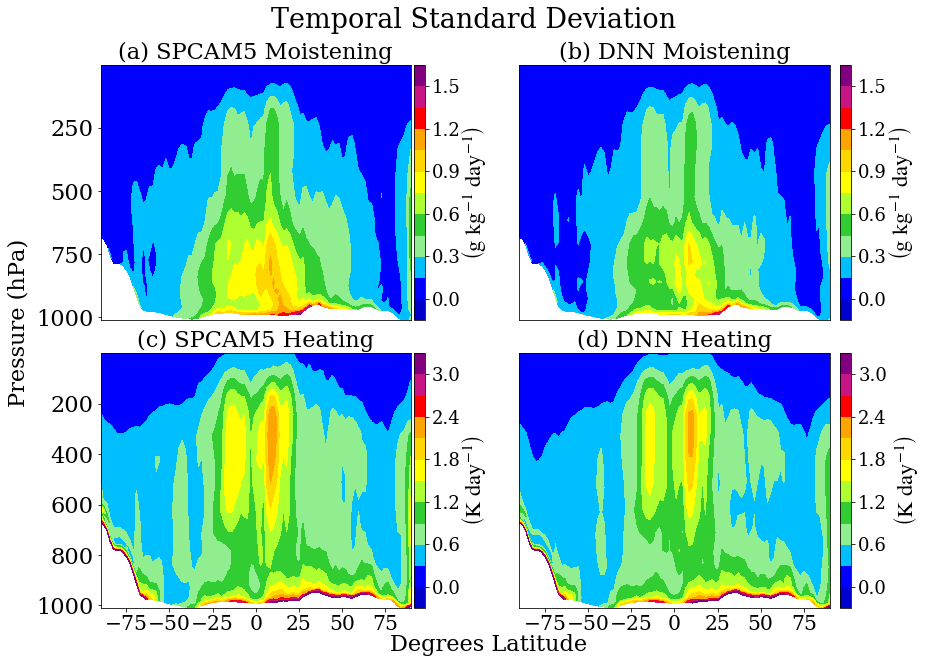

In [73]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 

cp = ax[0,0].contourf(SPCAM5_Xs, SPCAM5_pband, sd_truth_moist_avg, sd_moist_diff, cmap = cmap, vmin=-0.15, vmax=1.65)
ax[0,0].set_title("(a) SPCAM5 Moistening", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.415, 0.525, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[0,1].contourf(SPCAM5_Xs, SPCAM5_pband, sd_DNN_moist_avg, sd_moist_diff, cmap = cmap, vmin=-0.15, vmax=1.65)
ax[0,1].set_title("(b) DNN Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.58,-0.01)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.525, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1,0].contourf(SPCAM5_Xs, SPCAM5_pband, sd_truth_heat_avg, sd_heat_diff, cmap = cmap, vmin=-0.3, vmax=3.3)
ax[1,0].set_title("(c) SPCAM5 Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
#ax[1,0].set_xticks([])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.415, 0.125, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1,1].contourf(SPCAM5_Xs, SPCAM5_pband, sd_DNN_heat_avg, sd_heat_diff, cmap = cmap, vmin=-0.3, vmax=3.3)
ax[1,1].set_title("(d) DNN Heating", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
#ax[1,1].set_xticks([])
ax[1,1].set_xlabel("Degrees Latitude")
ax[1,1].xaxis.set_label_coords(-0.10,-0.1)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.125, 0.01, 0.355])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)


plt.suptitle("Temporal Standard Deviation", y = 0.96, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.35)
print(" ")

#plt.savefig("Figures/Figure12.png")
#plt.savefig("Figures/Figure12.pdf")

In [77]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_heat_diff.npy",sd_heat_diff)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_moist_diff.npy",sd_moist_diff)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_truth_moist_avg.npy",sd_truth_moist_avg)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_DNN_moist_avg.npy",sd_DNN_moist_avg)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_truth_heat_avg.npy",sd_truth_heat_avg)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_DNN_heat_avg.npy",sd_DNN_heat_avg)

In [16]:
precip_levels = np.linspace(-2,26,15)
diff_levels = np.linspace(-2.5,2.5,26)

Text(0.47, 0.99, 'Annual Mean Precipitation Error')

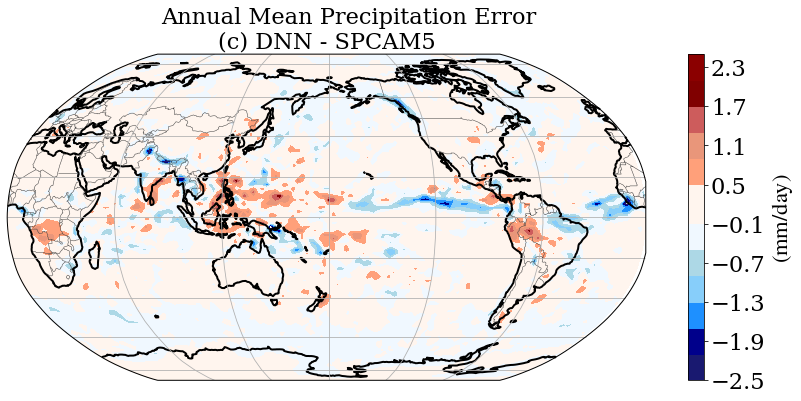

In [26]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)

In [27]:
heat_diff_levels = np.linspace(-2.1, 2.1, 13)
moist_diff_levels = np.linspace(-0.84, 0.84, 13)

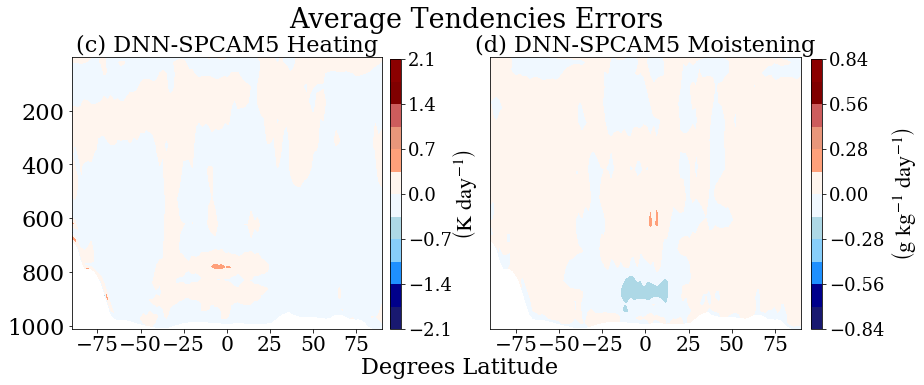

In [35]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)

cp = ax[0].contourf(SPCAM5_Xs, SPCAM5_pband, DNN_heat_avg-truth_heat_avg, heat_diff_levels, cmap = cmap, vmin=-2.10, vmax=2.10)
ax[0].set_title("(c) DNN-SPCAM5 Heating", fontsize = fz)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].locator_params(nbins=8)
ax[0].tick_params(axis='x', labelsize=fz*0.9)

cbar_ax = fig.add_axes([0.42, 0.125, 0.01, 0.75])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1].contourf(SPCAM5_Xs, SPCAM5_pband, DNN_moist_avg-truth_moist_avg, moist_diff_levels, cmap = cmap, vmin=-0.84, vmax=0.84)
ax[1].set_title("(d) DNN-SPCAM5 Moistening", fontsize = fz)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_yticks([])
ax[1].set_xlabel("Degrees Latitude")
ax[1].xaxis.set_label_coords(-0.10,-0.1)
ax[1].locator_params(nbins=8)
ax[1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.125, 0.01, 0.75])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
register_bottom_offset(cbar.ax.yaxis, bottom_offset)

plt.suptitle("Average Tendencies Errors", y = 1.02)
plt.subplots_adjust(hspace=0.13, wspace=0.35)
print(" ")

#plt.savefig("Figures/Figure12.png")
#plt.savefig("Figures/Figure12.pdf")

Text(0.47, 0.95, 'Prediction - Target Error')

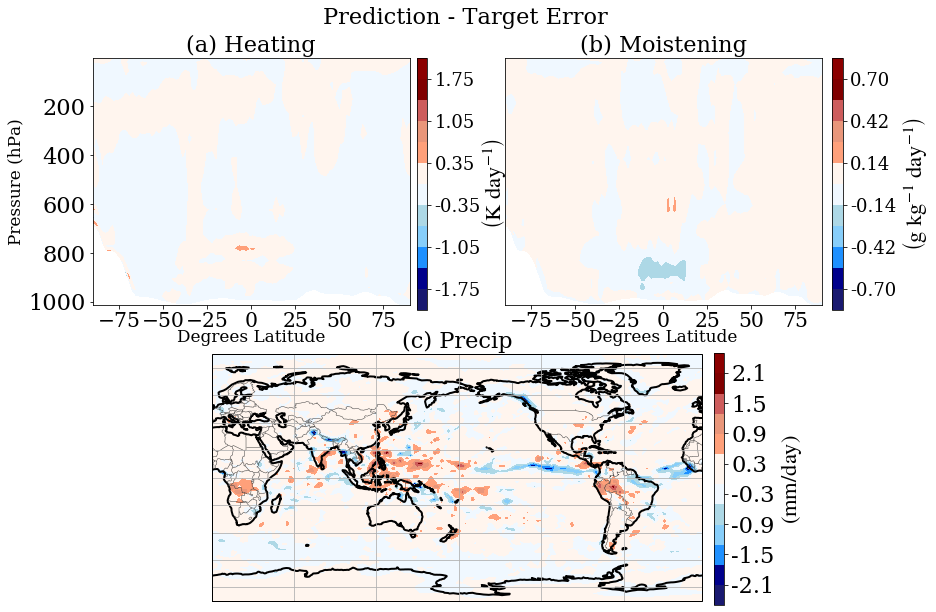

In [74]:
fig=plt.figure(figsize=(15,10))
gs=GridSpec(2,2) # 2 rows,  columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column 
ax3=fig.add_subplot(gs[1,:],projection=ccrs.PlateCarree(central_longitude=180)) # Second row, span all columns

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)

cp = ax1.contourf(SPCAM5_Xs, SPCAM5_pband, DNN_heat_avg-truth_heat_avg, heat_diff_levels, cmap = cmap, vmin=-2.10, vmax=2.10)
ax1.set_title("(a) Heating", fontsize = fz)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel("Pressure (hPa)", size=fz*0.75)
ax1.locator_params(nbins=8)
ax1.tick_params(axis='x', labelsize=fz*0.9)
ax1.set_xlabel("Degrees Latitude", fontsize=fz*0.75)
ax1.xaxis.set_label_coords(0.50,-0.1)

cbar_ax = fig.add_axes([0.425, 0.53, 0.01, 0.35])
cbar = fig.colorbar(cp, cax=cbar_ax, ticks=[-1.75,-1.05,-0.35,0.35,1.05,1.75])
cbar.ax.set_yticklabels(['-1.75', '-1.05', '-0.35','0.35','1.05','1.75'])
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax2.contourf(SPCAM5_Xs, SPCAM5_pband, DNN_moist_avg-truth_moist_avg, moist_diff_levels, cmap = cmap, vmin=-0.84, vmax=0.84)
ax2.set_title("(b) Moistening", fontsize = fz)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_yticks([])
ax2.set_xlabel("Degrees Latitude", fontsize=fz*0.75)
ax2.xaxis.set_label_coords(0.50,-0.1)
ax2.locator_params(nbins=8)
ax2.tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.53, 0.01, 0.35])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', cax=cbar_ax, ticks=[-0.7,-0.42,-0.14,0.14,0.42,0.70])
cbar.ax.set_yticklabels(['-0.70', '-0.42', '-0.14','0.14','0.42','0.70'])
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
register_bottom_offset(cbar.ax.yaxis, bottom_offset)

cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax3.contourf(Xvar, Yvar, diff,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
cbaxes = fig.add_axes([0.70, 0.12, 0.01, 0.35])
cbar = plt.colorbar(contour_plot, cax = cbaxes, label=r'$\left(\mathrm{mm/day}\right)$',ticks=[-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1]) 
cbar.ax.set_yticklabels(['-2.1', '-1.5', '-0.9','-0.3','0.3','0.9','1.5','2.1'])
ax3.set_title('(c) Precip', fontsize = fz)
ax3.coastlines(linewidth=2.0,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.20, wspace=0.30)
plt.suptitle("Prediction - Target Error", y=0.95, x=0.47, fontsize = fz)


In [75]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/heat_diff_levels.npy",heat_diff_levels)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/moist_diff_levels.npy",moist_diff_levels)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_levels.npy",diff_levels)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_heat_avg.npy",DNN_heat_avg-truth_heat_avg)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_moist_avg.npy",DNN_moist_avg-truth_moist_avg)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff.npy",diff)